In [1]:
%matplotlib inline
import altair as alt
import datashader as ds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from datashader import transfer_functions as tf

alt.data_transformers.enable('json')

%reload_ext watermark
%watermark -d -v -m -p altair,datashader,numpy,pandas,matplotlib,seaborn

2019-09-30 

CPython 3.6.7
IPython 7.2.0

altair 2.3.0
datashader 0.6.9
numpy 1.15.4
pandas 0.24.0
matplotlib 3.0.2
seaborn 0.9.0

compiler   : GCC 7.3.0
system     : Linux
release    : 5.2.11-200.fc30.x86_64
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


In [13]:
p = pd.read_csv(
    "../../data/results/probability-ctype_gene_protein-coding_CHH_Col-0_wt_rosette.bed",
    header=None,
    names="chrom start end name score strand hmc mmc msc lmc".split(),
    sep="\t"
)

t = pd.read_csv(
    "../../data/results/probability-ctype_gene_transposable-element_CHH_Col-0_wt_rosette.bed",
    header=None,
    names="chrom start end name score strand hmc mmc msc lmc".split(),
    sep="\t"
)

df = pd.concat([p, t], keys=["non-TE genes", "TE genes"], names=["gene"]).reset_index()

In [6]:
p = pd.read_csv(
    "../../data/results/probability-ctype_gene_expression-vegetative-rosette-top50_CpG_Col-0_wt_rosette.bed",
    header=None,
    names="chrom start end name score strand hmc mmc msc lmc".split(),
    sep="\t"
)

t = pd.read_csv(
    "../../data/results/probability-ctype_gene_expression-vegetative-rosette-bottom50_CpG_Col-0_wt_rosette.bed",
    header=None,
    names="chrom start end name score strand hmc mmc msc lmc".split(),
    sep="\t"
)

df = pd.concat([p, t], keys=["high expression", "low expression"], names=["gene"]).reset_index()

In [7]:
base = alt.Chart(df)
tick_axis = alt.Axis(labels=False, domain=False, ticks=False)

points = base.mark_point().encode(
    x="hmc:Q",
    y="lmc:Q",
    color="gene:N"
)

x_ticks = base.mark_tick(
    opacity=0.3,
).encode(
    alt.X("hmc:Q", axis=tick_axis),
    alt.Y("gene:N", axis=tick_axis),
    alt.Color("gene:N")
)

y_ticks = base.mark_tick(
    opacity=0.3,
).encode(
    alt.X("gene:N", axis=tick_axis),
    alt.Y("lmc:Q", axis=tick_axis),
    alt.Color("gene:N")
)

x_hist = base.mark_area(
    opacity=0.3,
    interpolate="step"
).encode(
    alt.X("hmc:Q", bin=True),
    alt.Y("count()", stack=None),
    alt.Color("gene:N")
)

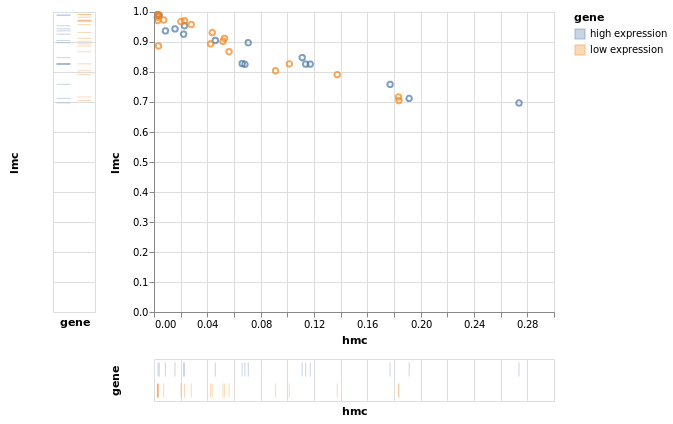

In [8]:
y_ticks | (points & x_ticks)

## Datashader phaseplane

In [3]:
input_div = "../../data/results/div_CpG_Col-0_wt_rosette.bed.gz"
data = pd.read_csv(input_div, sep="\t", header=0, usecols=[0, 3, 6, 7])
data['MET'] = data['5mC'] / (data['5mC'] + data['C'])
data.rename(columns={'JSD_bit_': 'JSD (bit)'}, inplace=True)
data = data[(data["#chrom"] !="Mt") | (data["#chrom"] != "Pt")]

/home/oender/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


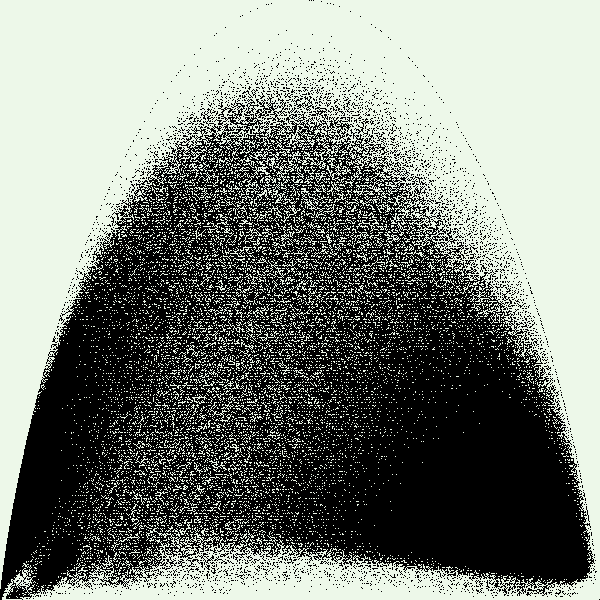

In [4]:
x = tf.shade(ds.Canvas().points(data, 'MET', 'JSD (bit)'), how='eq_hist', cmap=["black"])
tf.set_background(x, color="#edf8e9")

## Randomization plots

In [2]:
def count_mapped_features(bed, col_mapped=None, sep_mapped=None):
    """Return set size of targeted and mapped features."""
    targetset_size = len(bed)
    mapped = sum(bed.iloc[:, col_mapped].dropna().str.split(sep_mapped).tolist(), [])
    mappedset_size = len(set(mapped))
    return targetset_size, mappedset_size

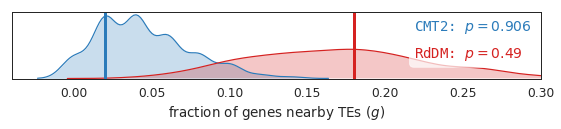

In [386]:
obs = {
    "CMT2": pd.read_csv(
        "../../data/results/genes-nearby-TEs_expression-mature-pollen-bottom50_CMT2-targets.bed", 
        header=None,
        sep="\t",
    ),
    "RdDM": pd.read_csv(
        "../../data/results/genes-nearby-TEs_expression-mature-pollen-bottom50_RdDM-targets.bed", 
        header=None,
        sep="\t",
    ),
}

rnd = {
    "CMT2": pd.read_csv("../../data/results/genes-nearby-TEs_random-50_draws-1e3_CMT2-targets_count.csv", header=0, index_col="sample_id").astype('int32'),
    "RdDM": pd.read_csv("../../data/results/genes-nearby-TEs_random-50_draws-1e3_RdDM-targets_count.csv", header=0, index_col="sample_id").astype('int32'),
}

size = 50

# Set up the figure
sns.set(style="white")
# sns.despine(offset=20, trim=True)
sns.set_context("paper", font_scale=1.4)

f, ax = plt.subplots(figsize=(8, 2))

color = dict()
color["CMT2"] = sns.color_palette("Blues")[-2]
color["RdDM"] = sns.color_palette("Reds")[-2]

# Draw the two density plots
ax = sns.distplot(rnd["CMT2"]["genes"]/size, hist=False, kde_kws={"shade": True}, color=color["CMT2"])
ax = sns.distplot(rnd["RdDM"]["genes"]/size, hist=False, kde_kws={"shade": True}, color=color["RdDM"])

props = dict(boxstyle='round', facecolor='white', alpha=0.7)

# Add observed values
for key, data in obs.items():
    obs_ = count_mapped_features(data, col_mapped=-2, sep_mapped=",")
    ax.axvline(obs_[0]/size, c=color[key], linewidth=3, linestyle="-")
    pvalue = emp_pvalue(rnd[key]["genes"], obs_[0])
    textstr = r"{}: $p={}$".format(key, pvalue)
    x = 0.76
    y = 0.9 if key == "CMT2" else 0.5
    ax.text(x, y, textstr, transform=ax.transAxes, 
            size=14, color=color[key], bbox=props, 
            verticalalignment='top', family='monospace')

ax.set_xlabel(r"fraction of genes nearby TEs ($g$)")
ax.set_yticks([])
ax.set_xlim([-0.04, 0.3])

plt.tight_layout()

In [314]:
rnd["CMT2"]["genes"]

sample_id
1       0.10
2       0.02
3       0.02
4       0.06
5       0.02
6       0.00
7       0.04
8       0.02
9       0.04
10      0.10
11      0.00
12      0.06
13      0.04
14      0.08
15      0.02
16      0.04
17      0.02
18      0.06
19      0.02
20      0.04
21      0.06
22      0.00
23      0.10
24      0.04
25      0.00
26      0.02
27      0.08
28      0.02
29      0.02
30      0.00
        ... 
971     0.04
972     0.10
973     0.02
974     0.08
975     0.10
976     0.02
977     0.02
978     0.02
979     0.02
980     0.02
981     0.02
982     0.04
983     0.04
984     0.02
985     0.06
986     0.08
987     0.08
988     0.06
989     0.06
990     0.00
991     0.04
992     0.04
993     0.00
994     0.06
995     0.02
996     0.08
997     0.06
998     0.02
999     0.00
1000    0.00
Name: genes, Length: 1000, dtype: float64

In [10]:
def emp_pvalue(random, observed, greater=True):
    """Empirical p-value for testing observed value against random vector.
    """
    try:
        if greater:
            return sum(random >= observed) / len(random)
        else:
            return sum(random <= observed) / len(random)
    except ZeroDivisionError as e:
        raise ValueError("Invalid random vector") from e
    except TypeError as e:
        raise ValueError("Invalid comparison") from e


In [228]:
hicobs = pd.read_csv("../../data/results/HiC-domains_observed_mean.csv", header=0, usecols=[0,1,2,3,4], index_col=[2,3,4])
hicrnd = pd.read_csv("../../data/results/HiC-domains_random_mean.csv", header=0, usecols=[0,1,2,3,4], index_col=[2,3,4])
hicrnd.sort_index(inplace=True) # avoid performance warning when indexing
hicobs.sort_index(inplace=True)

[0.0812999041378101, 0.0812999041378101]

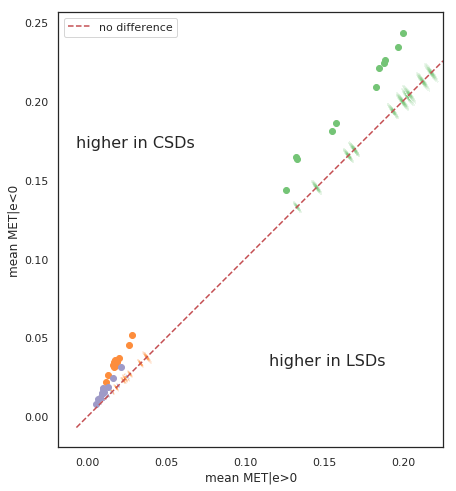

In [256]:
f, ax = plt.subplots(figsize=(8, 8))

ax.set_aspect("equal")

colors_context = {'CG': '#74c476', 'CHG': '#fd8d3c', 'CHH': '#9e9ac8'}

cmap = dict()

for key, val in colors_context.items():
    cmap[key] = mpl.colors.LinearSegmentedColormap.from_list(
        key, [(0, 'white'), (1, val)])

sig = 'MET'

for ctx in hicrnd.index.unique(level='context'):
    for src in hicrnd.index.unique(level='src'):
        i = (sig, ctx, src)
        ax = sns.kdeplot(hicrnd.loc[i]['mean|e>0'], 
                         hicrnd.loc[i]['mean|e<0'],
                         shade=True,
                         shade_lowest=False,
                         cmap=cmap[ctx])
        ax.scatter(*hicobs.loc[i], c=colors_context[ctx])

ax.plot(ax.get_xlim(), ax.get_xlim(), 'r--', label='no difference')

bboxprops = dict(boxstyle='round', facecolor='white', alpha=0.7)

ax.text(.2, .7, 'higher in CSDs', bbox=bboxprops, 
        ha='center', va='center', transform=ax.transAxes,
        size=16)

ax.text(.7, .2, 'higher in LSDs', bbox=bboxprops,
        ha='center', va='center', transform=ax.transAxes,
        size=16)

ax.set_xlabel(ax.get_xlabel().replace("mean", "mean {}".format(sig)))
ax.set_ylabel(ax.get_ylabel().replace("mean", "mean {}".format(sig)))
ax.legend(loc=2)
# plt.tight_layout()

In [420]:
data = pd.read_csv("../../data/results/tab-pvalues_HiC-domains_mean.csv",header=0)

data["count"] = data.groupby(["source", "context"])["count"].transform(lambda x: 100 * x/x.sum())
data.rename(columns={"count": "proportion (%)"}, inplace=True)
data["context"] = data["context"].replace({"CpG": "CG"})

In [423]:
data = pd.read_csv("../../data/results/stats_Col-0_wt.",header=0)

In [427]:
data.set_index(['src', 'context', 'signal']).unstack(['signal', 'context']).head()

p-value                         
signal                   JSD            MET          
context                   CG  CHG  CHH   CG  CHG  CHH
src                                                  
aerial part              0.0  0.0  0.0  0.0  0.0  0.0
embryo                   0.0  0.0  0.0  0.0  0.0  0.0
endosperm                0.0  0.0  0.0  0.0  0.0  0.0
immature flower buds     0.0  0.0  0.0  0.0  0.0  0.0
inflorescence            0.0  0.0  0.0  0.0  0.0  0.0

In [422]:
data.sort_values(["source", "context", "C-type"]).set_index(['source', 'context', 'C-type']).unstack('context').head(12)

proportion (%)                      
context                        CG        CHG        CHH
source      C-type                                     
aerial-part HMC         26.257259   2.871774   0.251096
            LMC         65.411507  81.997302  92.419525
            MMC          7.781536  14.593772   6.457217
            MSC          0.549699   0.537153   0.872162
embryo      HMC         23.488076   4.619464   0.542414
            LMC         72.074742  86.675034  93.319979
            MMC          4.155613   8.205923   5.755131
            MSC          0.281568   0.499579   0.382476
endosperm   HMC         11.691719   2.569454   0.110229
            LMC         73.212644  87.943431  95.901762
            MMC         14.007859   8.807468   3.659375
            MSC          1.087778   0.679647   0.328634

In [2]:
from pandas.plotting import parallel_coordinates

In [41]:
data_imp = pd.read_csv("../../data/results/probability-ctype_gene_imprinted_CpG_Col-0_wt_rosette.bed", header=None, names=["chrom", "start", "end", "name", "score", "strand", "HMC", "MMC", "MSC", "LMC"], sep="\t")
data_all = pd.read_csv("../../data/results/probability-ctype_gene_protein-coding-0kb-flank_CpG_Col-0_wt_rosette.bed", header=None, names=["chrom", "start", "end", "name", "score", "strand", "HMC", "MMC", "MSC", "LMC"], sep="\t")

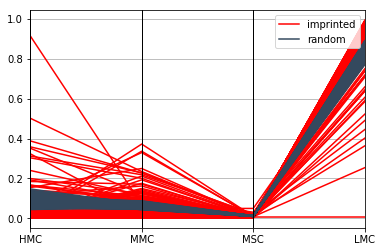

In [98]:
parallel_coordinates(data.reset_index(), 'gene', cols="HMC MMC MSC LMC".split(), color=["red", "#34495e"])

In [84]:
def sample_rep(df, n=None, replicates=None):
    for i in range(replicates):
        yield df.sample(n)

In [85]:
r = 1000
dc = pd.concat(sample_rep(data_all, n=len(data_imp), replicates=r), 
               keys=range(1, r + 1), names=["replicate"])

In [97]:
data = pd.concat({"imprinted": data_imp["HMC MMC MSC LMC".split()], "random": dc["HMC MMC MSC LMC".split()].mean(level="replicate")}, names=["gene"], axis=0)

In [91]:
dc.head()

chrom     start       end       name score strand       HMC  \
replicate                                                                     
1         6087      3   2915549   2916870  AT3G09490     .      +  0.008197   
          6007      3   2404492   2407634  AT3G07540     .      -  0.004386   
          7305      3  14302059  14303018  AT3G42140     .      -  0.885714   
          3932      2   7024606   7025231  AT2G16200     .      +  0.025000   
          1489      1  10496729  10497287  AT1G29962     .      +  0.018519   

                     MMC       MSC       LMC  
replicate                                     
1         6087  0.008197  0.008197  0.975410  
          6007  0.004386  0.004386  0.986842  
          7305  0.085714  0.014286  0.014286  
          3932  0.125000  0.025000  0.825000  
          1489  0.018519  0.018519  0.944444